# Split datasets


In [13]:
import json
import os
import shutil
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [14]:
seed = 19
split_ratio_1 = 0.2  # (validation+test) / (train+validation+test)
split_ratio_2 = 0.5  # (test) / (validation+test)

# label_map_csv = "../datasets/cassava-leaf-disease-classification/train.csv"

# --------------------------

label_map_csv = "../datasets/PAD-UFES-20/metadata.csv"
images_root = "../datasets/PAD-UFES-20/images/"
target_column = "diagnostic"
file_column = "img_id"
group_columns = ["patient_id"]  # , "lesion_id"

label_map_csv = "../datasets/ddi-diverse-dermatology-images/ddi_metadata.csv"
images_root = "../datasets/ddi-diverse-dermatology-images/"
target_column = "malignant" # "disease"
file_column = "DDI_file"
group_columns = []


label_map_csv = ("../datasets/HAM10000/HAM10000_metadata", "../datasets/HAM10000/ISIC2018_Task3_Test_GroundTruth.csv") # Given test dataset
# NOTE: The image 'ISIC_0035068' (known as the 'easter egg') is corrupted and was therefore excluded manually from the test dataset!
images_root = "../datasets/HAM10000/images/"
target_column = "dx"
file_column = "image_id"
group_columns = ["lesion_id"]

label_map_csv = "../datasets/fitzpatrick17k/fitzpatrick17k.csv"
images_root = "../datasets/fitzpatrick17k/images/"
target_column = "three_partition_label" # "nine_partition_label"
file_column = "md5hash" # "url"
group_columns = []

label_map_csv = None
images_root = "../datasets/PlantDataset/"
target_column = "disease"
file_column = "filename"
group_columns = []

In [22]:
target_column_values = []
target_column_values.extend(["A"])
target_column_values

['A']

In [46]:
df_full = None
df_full_test = None
file_column_values = []
if label_map_csv is None:
    target_column = "."
    target_column_values = []
    target_dirs = [name for name in os.listdir(path=images_root) if os.path.isdir(os.path.join(images_root, name))]
    for target_dir in target_dirs:
        image_file_names = [name for name in os.listdir(path=os.path.join(images_root, target_dir)) if os.path.isfile(os.path.join(images_root, target_dir, name))]
        file_column_values.extend(image_file_names)
        target_column_values.extend([target_dir] * len(image_file_names))
    df_full = pd.DataFrame(list(zip(target_column_values, file_column_values)), columns=[target_column, file_column])
elif type(label_map_csv) is tuple:
    df_full = pd.read_csv(label_map_csv[0])
    df_full_test = pd.read_csv(label_map_csv[1])
else:
    df_full = pd.read_csv(label_map_csv)
assert target_column in df_full.columns.values
assert file_column in df_full.columns.values
print(f"Columns: {list(df_full.columns)}")

number_of_image_files = len([name for name in os.listdir(path=images_root) if os.path.isfile(os.path.join(images_root, name))]) + len(file_column_values)
print(f"Number of images: {number_of_image_files}")
number_of_rows = df_full[target_column].size
print(f"Number of rows: {number_of_rows}")

number_of_rows_test = 0
if df_full_test is not None:
    assert list(df_full.columns) == list(df_full_test.columns)
    number_of_rows_test = df_full_test[target_column].size
    print(f"Number of rows test: {number_of_rows_test}")

assert number_of_image_files == number_of_rows + number_of_rows_test
df_full.groupby(target_column).count()


Columns: ['.', 'filename']
Number of images: 5106
Number of rows: 5106


,filename
.,
Apple Aphis spp(162),162
Apple Eriosoma lanigerum(366),366
Apple Monillia laxa(255),255
Apple Venturia inaequalis(633),633
Apricot Coryneum beijerinckii(1101),1101
Apricot Monillia laxa(85),85
Cancer symptom(76),76
Cherry Aphis spp(356),356
Downy mildew(120),120


In [31]:
# NOTE: Only used to download Fitzpatrick17k images from original source, but many links are dead. It is better to download the dataset from the Google Drive.
#  
# if "url" in df_full.columns:
#     for image_url in df_full["url"]:
#         file_name = None
#         if str(image_url) == "nan":
#             # print(f"image_url: {image_url}")
#             continue
#         elif str(image_url).startswith("https://www.dermaamin.com"):
#             continue
#         elif str(image_url).startswith("http://atlasdermatologico.com.br/img"):
#             continue

#         file_name = os.path.basename(image_url)
#         file_name = file_name.replace("?", "")
#         file_path = os.path.join(images_root, file_name)

#         if not os.path.exists(file_path):
#             response = requests.get(
#                 image_url, stream=True, headers={"User-Agent": "XY"}
#             )
#             if not response.ok:
#                 print(f"image_url: {image_url}")
#                 print(response)
#                 continue

#             with open(file_path, "wb") as handle:
#                 for block in response.iter_content(1024):
#                     if not block:
#                         break
#                     handle.write(block)
# else:
#     print("Skip download")

In [47]:
def copy_images_to_target_subdirectory(df):
    if label_map_csv is None:
        return
    image_file_names = [name for name in os.listdir(path=images_root) if os.path.isfile(os.path.join(images_root, name))]
    for value in df[target_column].unique():
        subdirectory = os.path.join(images_root, target_column, str(value))
        print(f"Copying to {subdirectory}")
        os.makedirs(subdirectory, exist_ok=True)
        for image_path in df[df[target_column] == value][file_column]:
            if str(image_path) == "nan":
                print(image_path)
                continue
            image_name = os.path.basename(image_path)
            image_name = image_name.replace("?", "")
            file_extension = os.path.splitext(image_name)[1]

            if file_extension == '':
                found_image_names = [image_file_name for image_file_name in image_file_names if image_file_name.startswith(image_name)]
                if 1 != len(found_image_names):
                    print(f"Image name '{image_name}' cannot be assigned to existing files: {found_image_names}")
                assert  1 == len(found_image_names)
                image_name = found_image_names[0]

            source_path = os.path.join(images_root, image_name)

            if os.path.exists(source_path):
                if not os.path.exists(os.path.join(subdirectory, image_name)):
                    shutil.copy(source_path, f"{subdirectory}/")
            else:
                print(f"Missing file: {source_path}")

copy_images_to_target_subdirectory(df_full)
if df_full_test is not None:
    copy_images_to_target_subdirectory(df_full_test)

In [48]:
def check_stratify(groups, verbose=False):
    for name, group in groups:
        sub_groups = group.groupby(target_column)
        for sub_name, sub_group in sub_groups:
            if verbose:
                print(f"{name}: {sub_name}")
            if 1 < len(sub_groups):
                print(group[[*group_columns, target_column]])
                return False
    return True

groups = None
groupby_columns = [df_full.index]
if group_columns == []:
    groups = df_full.groupby(groupby_columns)
    assert len(groups) == len(df_full)
else:
    groupby_columns = group_columns
    groups = df_full.groupby(groupby_columns)
    assert len(groups) < len(df_full)
stratify_possible = check_stratify(groups)

if stratify_possible:
    previous_length = len(groups)
    groups = df_full.groupby([*groupby_columns, target_column])
    assert previous_length == len(groups)
    
df_grouped = groups.size().reset_index()
assert len(df_grouped[group_columns]) == len(groups.groups.keys())

In [49]:
def split_sets(set_combined, split_ratio):
    if 0 == split_ratio:
        return set_combined, set_combined.iloc[:0,:].copy()
    
    stratify_series = None
    if stratify_possible:
        stratify_series = set_combined[target_column]

    return train_test_split(
        set_combined,
        test_size=split_ratio,
        random_state=seed,
        stratify=stratify_series
    )

if df_full_test is not None:
    split_ratio_1 = split_ratio_1 * (1 - split_ratio_2) / (1 - split_ratio_1 * split_ratio_2)
    split_ratio_2 = 0

df_train, df_valid_test = split_sets(df_grouped, split_ratio_1)
df_valid, df_test = split_sets(df_valid_test, split_ratio_2)

train_ids = df_train[group_columns].values
valid_ids = df_valid[group_columns].values
test_ids = df_test[group_columns].values

if group_columns == []:
    train_ids = df_train.index.values
    valid_ids = df_valid.index.values
    test_ids = df_test.index.values


In [50]:
def get_set(values):
    group_id = tuple(values)
    if 1 == len(group_id):
        group_id = group_id[0]

    if group_id in train_ids:
        return "train"
    elif group_id in valid_ids:
        return "valid"
    elif group_id in test_ids:
        return "test"
    else:
        print(f"Group_id '{group_id}' cannot be assigned")
        return None


df_split = df_full[[target_column, file_column]].copy()
original_columns = df_split.columns
new_columns = ["target_code", "filename"]

df_split.columns = new_columns

if group_columns == []:
    df_split["set"] = df_full.index.to_frame().apply(get_set, axis=1)
else:
    df_split["set"] = df_full[groupby_columns].apply(get_set, axis=1)

if df_full_test is not None:
    pd.options.mode.chained_assignment = None
    df_split_test = df_full_test[original_columns]
    df_split_test.columns = new_columns
    df_split_test["set"] = "test"
    assert 0 == (df_split["set"] == "test").sum()
    df_split = pd.concat([df_split, df_split_test])

In [51]:
df_test = df_split[df_split["set"] == "train"]
df_test.groupby("target_code")["filename"].count() / len(df_test)

target_code
Apple Aphis spp(162)                   0.031832
Apple Eriosoma lanigerum(366)          0.071743
Apple Monillia laxa(255)               0.049951
Apple Venturia inaequalis(633)         0.123898
Apricot Coryneum beijerinckii(1101)    0.215720
Apricot Monillia laxa(85)              0.016650
Cancer symptom(76)                     0.014936
Cherry Aphis spp(356)                  0.069785
Downy mildew(120)                      0.023506
Drying symptom(156)                    0.027179
Gray mold(72)                          0.014202
Leaf scars(140)                        0.027424
Peach Monillia laxa(314)               0.061459
Peach Parthenolecanium corni(427)      0.083497
Pear Erwinia amylovora(215)            0.042116
Plum Aphis spp(70)                     0.013712
RoughBark(158)                         0.030852
StripeCanker(168)                      0.032811
Walnut Eriophyes erineus(69)           0.013467
Walnut Gnomonia leptostyla(180)        0.035260
Name: filename, dtype: float

In [52]:
df_valid = df_split[df_split["set"] == "valid"]
df_valid.groupby("target_code")["filename"].count() / len(df_valid)

target_code
Apple Aphis spp(162)                   0.031311
Apple Eriosoma lanigerum(366)          0.072407
Apple Monillia laxa(255)               0.050881
Apple Venturia inaequalis(633)         0.123288
Apricot Coryneum beijerinckii(1101)    0.215264
Apricot Monillia laxa(85)              0.017613
Cancer symptom(76)                     0.015656
Cherry Aphis spp(356)                  0.068493
Downy mildew(120)                      0.023483
Drying symptom(156)                    0.027397
Gray mold(72)                          0.013699
Leaf scars(140)                        0.027397
Peach Monillia laxa(314)               0.060665
Peach Parthenolecanium corni(427)      0.084149
Pear Erwinia amylovora(215)            0.041096
Plum Aphis spp(70)                     0.013699
RoughBark(158)                         0.031311
StripeCanker(168)                      0.033268
Walnut Eriophyes erineus(69)           0.013699
Walnut Gnomonia leptostyla(180)        0.035225
Name: filename, dtype: float

In [53]:
df_test = df_split[df_split["set"] == "test"]
df_test.groupby("target_code")["filename"].count() / len(df_test)

target_code
Apple Aphis spp(162)                   0.031311
Apple Eriosoma lanigerum(366)          0.070450
Apple Monillia laxa(255)               0.048924
Apple Venturia inaequalis(633)         0.125245
Apricot Coryneum beijerinckii(1101)    0.215264
Apricot Monillia laxa(85)              0.015656
Cancer symptom(76)                     0.013699
Cherry Aphis spp(356)                  0.070450
Downy mildew(120)                      0.023483
Drying symptom(156)                    0.027397
Gray mold(72)                          0.013699
Leaf scars(140)                        0.027397
Peach Monillia laxa(314)               0.062622
Peach Parthenolecanium corni(427)      0.084149
Pear Erwinia amylovora(215)            0.043053
Plum Aphis spp(70)                     0.013699
RoughBark(158)                         0.031311
StripeCanker(168)                      0.033268
Walnut Eriophyes erineus(69)           0.013699
Walnut Gnomonia leptostyla(180)        0.035225
Name: filename, dtype: float

In [54]:
df_split.to_csv(os.path.join(images_root, target_column, "split.csv"))

In [168]:
def plot_example_images(title, image_paths):
    number_of_columns = len(image_paths)
    number_of_rows = len(image_paths[0])
    fig, ax = plt.subplots(
        number_of_columns,
        number_of_rows,
        figsize=(3 * number_of_rows, 3 * number_of_columns),
        squeeze=False,
    )

    fig.suptitle(title)
    for row in range(len(image_paths)):
        for column in range(len(image_paths[0])):
            image_path = image_paths[row][column]
            pil_im = Image.open(image_path, "r")
            title = os.path.basename(image_path)
            ax[row][column].imshow(pil_im)
            ax[row][column].set_title(title)
            ax[row][column].axis("off")

    fig.tight_layout()
    plt.show()


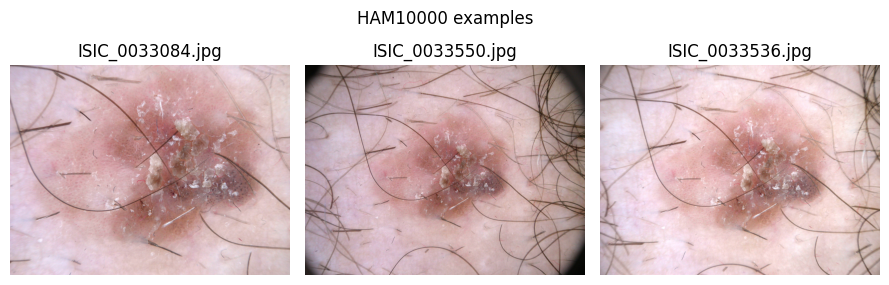

In [169]:
image_paths = [
    [
        "../datasets/HAM10000/images/ISIC_0033084.jpg",
        "../datasets/HAM10000/images/ISIC_0033550.jpg",
        "../datasets/HAM10000/images/ISIC_0033536.jpg",
    ],
]
plot_example_images("HAM10000 examples", image_paths)

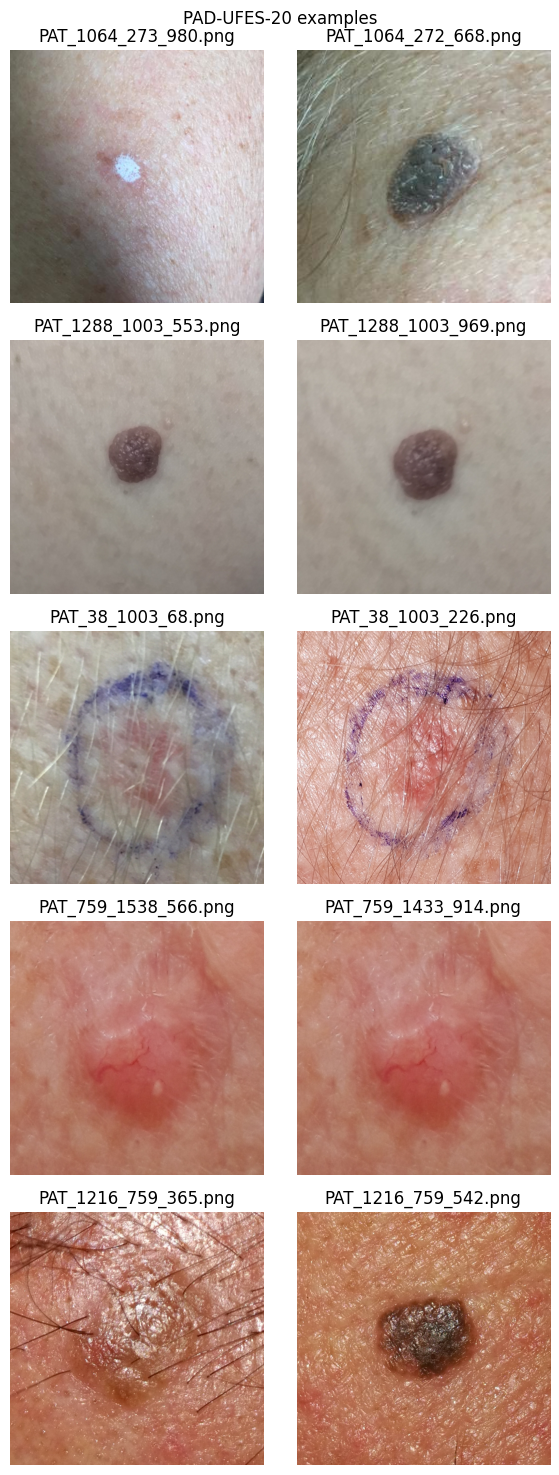

In [170]:
# NOTE: grouping is tricky. Examples:
# PAT_1064_272_668, PAT_1064_273_980
# PAT_759_1538_566, PAT_759_1433_914
# PAT_1216_759_365, PAT_1216_759_542

# Different lesions should not get mixed up
# Sometimes different lesions have the same image

# <patient_id>_<lesion_id>_<image_number>.png
image_paths = [
    [
        "../datasets/PAD-UFES-20/images/PAT_1064_273_980.png",
        "../datasets/PAD-UFES-20/images/PAT_1064_272_668.png",
    ],
    [
        "../datasets/PAD-UFES-20/images/PAT_1288_1003_553.png",
        "../datasets/PAD-UFES-20/images/PAT_1288_1003_969.png",
    ],
    [
        "../datasets/PAD-UFES-20/images/PAT_38_1003_68.png",
        "../datasets/PAD-UFES-20/images/PAT_38_1003_226.png",
    ],
    [
        "../datasets/PAD-UFES-20/images/PAT_759_1538_566.png",
        "../datasets/PAD-UFES-20/images/PAT_759_1433_914.png",
    ],
    [
        "../datasets/PAD-UFES-20/images/PAT_1216_759_365.png",
        "../datasets/PAD-UFES-20/images/PAT_1216_759_542.png",
    ],
]
plot_example_images("PAD-UFES-20 examples", image_paths)

In [21]:
# df_train, df_test = train_test_split(
#     df_full, test_size=test_ratio, stratify=df_full["label"], random_state=seed
# )
# print(df_train["label"].value_counts())
# print(df_test["label"].value_counts())

# _, df_train_mini = train_test_split(
#     df_train, test_size=0.1, stratify=df_train["label"], random_state=seed
# )
# print(df_train_mini["label"].value_counts())

In [22]:
# entries = json.load(
#     open(
#         "../datasets/cassava-leaf-disease-classification/label_num_to_disease_map.json"
#     )
# )
# entries

In [23]:
# for key in entries:
#     value = entries[key]
#     os.makedirs(f"../datasets/cassava-dataset/train/{value}/", exist_ok=True)
#     os.makedirs(f"../datasets/cassava-dataset/test/{value}/", exist_ok=True)
#     os.makedirs(f"../datasets/cassava-dataset/train-mini/{value}/", exist_ok=True)

In [24]:
# for index, row in df_test.iterrows():
#     image_id = row["image_id"]
#     label_key = row["label"]
#     shutil.copy(
#         f"../datasets/cassava-leaf-disease-classification/train_images/{image_id}",
#         f"../datasets/cassava-dataset/test/{entries[str(label_key)]}/"
#     )

In [25]:
# for index, row in df_train.iterrows():
#     image_id = row["image_id"]
#     label_key = row["label"]
#     shutil.copy(
#         f"../datasets/cassava-leaf-disease-classification/train_images/{image_id}",
#         f"../datasets/cassava-dataset/train/{entries[str(label_key)]}/"
#     )

In [26]:
# for index, row in df_train_mini.iterrows():
#     image_id = row["image_id"]
#     label_key = row["label"]
#     shutil.copy(
#         f"../datasets/cassava-leaf-disease-classification/train_images/{image_id}",
#         f"../datasets/cassava-dataset/train-mini/{entries[str(label_key)]}/"
#     )